<a href="https://colab.research.google.com/github/SirDEM0N/Algorithmic_Trading_Strategies/blob/main/Garch_Model_indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GARCH Model as indicator

* Using simulated daily data
* Load Daily
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.



In [1]:
!pip install yfinance
!pip install arch
!pip install pandas_ta
!pip install matplotlib
!pip install numpy
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=d62e44be3b46740bda1c922a41a7d5cfe98d74b4c475ce3159b37a327d6ec26a
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

* Finding the best p, q parameters using AIC.
* Fiting the GARCH model with the optimal p, q.
* Generating predictions for volatility.

In [2]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas as pd
import numpy as np
import yfinance as yf
from itertools import product

# Define stock ticker and period
ticker = "TSLA"
period = "9y"

# Fetch daily data
daily_df = yf.download(ticker, period=period, interval="1d")

# Compute log returns
daily_df['log_ret'] = np.log(daily_df['Close']).diff()

# Compute rolling variance
daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df.dropna()

# Function to find the best p, q parameters
def find_best_garch_params(log_returns, max_p=3, max_q=3):
    best_aic = np.inf
    best_p, best_q = None, None

    for p, q in product(range(1, max_p + 1), range(1, max_q + 1)):
        try:
            model = arch_model(y=log_returns, p=p, q=q)
            result = model.fit(disp='off')

            if result.aic < best_aic:
                best_aic = result.aic
                best_p, best_q = p, q
        except:
            continue

    print(f"Best p, q found: p={best_p}, q={best_q} with AIC={best_aic}")
    return best_p, best_q

# Find the best parameters
best_p, best_q = find_best_garch_params(daily_df['log_ret'].dropna())

# Function to predict volatility
def predict_volatility(x, p, q):
    model = arch_model(y=x, p=p, q=q)
    best_model = model.fit(disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    return variance_forecast

# Apply rolling prediction
daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x, best_p, best_q))

daily_df = daily_df.dropna()

print(daily_df.head())



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001474. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001474. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/py

Best p, q found: p=1, q=1 with AIC=-7897.6839392732


Streaming output truncated to the last 5000 lines.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001836. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by eit

Price           Close       High        Low       Open    Volume   log_ret  \
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA             
Date                                                                         
2017-08-31  23.726667  23.896000  23.521334  23.570000  61092000  0.007672   
2017-09-01  23.693333  23.839333  23.579332  23.741333  45742500 -0.001406   
2017-09-05  23.306000  23.699333  23.059334  23.586666  57526500 -0.016483   
2017-09-06  22.968666  23.398666  22.770666  23.299999  61371000 -0.014580   
2017-09-07  23.374001  23.498667  22.896667  23.065332  63588000  0.017493   

Price       variance predictions  
Ticker                            
Date                              
2017-08-31  0.000502    0.000505  
2017-09-01  0.000502    0.000503  
2017-09-05  0.000504    0.000500  
2017-09-06  0.000503    0.000588  
2017-09-07  0.000504    0.000581  


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002018. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: 

## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [3]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()
daily_df['signal_daily'] = np.where(daily_df['prediction_premium'] > daily_df['premium_std'], 1,
                                   np.where(daily_df['prediction_premium'] < daily_df['premium_std'] * -1, -1, np.nan))

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

<ipython-input-3-4ffa79a8de30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']
<ipython-input-3-4ffa79a8de30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()
<ipython-input-3-4ffa79a8de30>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

Price,Close,High,Low,Open,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,,,,,
Date,,,,,,,,,,,
2017-08-31,23.726667,23.896000,23.521334,23.570000,61092000,0.007672,0.000502,0.000505,0.005282,NaN,NaN
2017-09-01,23.693333,23.839333,23.579332,23.741333,45742500,-0.001406,0.000502,0.000503,0.002120,NaN,NaN
2017-09-05,23.306000,23.699333,23.059334,23.586666,57526500,-0.016483,0.000504,0.000500,-0.006761,NaN,NaN
2017-09-06,22.968666,23.398666,22.770666,23.299999,61371000,-0.014580,0.000503,0.000588,0.169527,NaN,NaN
2017-09-07,23.374001,23.498667,22.896667,23.065332,63588000,0.017493,0.000504,0.000581,0.152615,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,288.140015,288.200012,271.279999,283.600006,150361500,0.034423,0.002011,0.002010,-0.000290,0.162628,NaN
2025-03-26,272.059998,284.899994,266.510010,282.660004,153629800,-0.057424,0.002030,0.002293,0.129720,0.162521,NaN


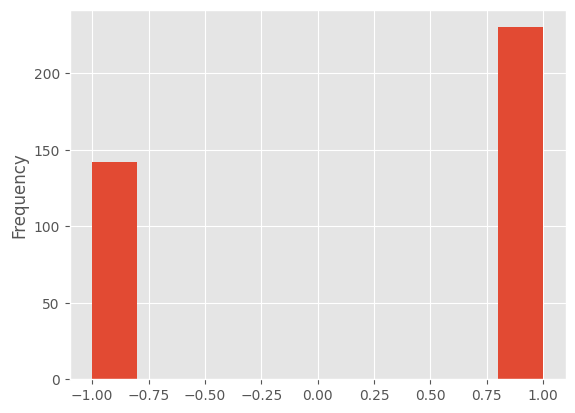

In [4]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()